In [2]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
import time

Compare model on beginning page of presentation and compare it to this model


# Load wikipedia growth dataset (directly from https://networks.skewed.de/net/wikipedia_growth)

I also loaded the datetime package since the source files contain time stamps in the UNIX format. The datetime package allows me to convert these timestamps into meaningful dates and to separate the edge data into the different years of observation. The data set contains information on the wikipedia network growth between 2001 and 2008. For this assignment, it might be interesting to compare the network once for each year of observation, thus for 8 points in time in total.

In [19]:
g = gt.collection.ns["wikipedia_growth"]
g.save("wikipedia_growth.gt")

In [3]:
g = gt.load_graph("wikipedia_growth.gt")

## General characteristics

Printing the networks general characteristics, we can retrieve that it contains roughly two million nodes (articles) and nearly 40 million edges (hyperlinks between the articles). Moreover, it contains some additional edge and vertex properties which we can inspect in the next step. 

In [21]:
print(g)

<Graph object, directed, with 1870709 vertices and 39953145 edges, 1 internal vertex property, 2 internal edge properties, 7 internal graph properties, at 0x3528c2450>


Printing the network's edge and vertex properties shows that we have information on the edge's weights as well as timestamps (indicating the point in time where an article was linked to another article with a hyperlink). The additional vertex porpoerty indicates its position in the network. When inspecting the weight property, it becomes evident that each edge's weight is equal to 1, hence the network is substantially unweighted. 

In [22]:
print(g.ep)
print(g.vp)

{'weight': <EdgePropertyMap object with value type 'bool', for Graph 0x3528c2450, at 0x350cc4750>, 'time': <EdgePropertyMap object with value type 'int32_t', for Graph 0x3528c2450, at 0x35274d4d0>}
{'_pos': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x3528c2450, at 0x3522baa90>}


Before plotting, I briefly calculate some key characteristics of the network. As we can see from the output, the average degree in the network is roughly 43, indicating that the average node combines 43 hyperlinks. Morover, the maximum in-degree is 225,883, indicating that there is an article that is hyperlinked in 225,883 other articles. The maximum out-degree is 6975. Thus, there is an article that contains nearly 7,000 hyperlinks to related articles. Interestingly, the mode of degree (most common degree) is 1. Hence, there is a bulk of articles that are only linked once/link only on other article. However, this is only true for the whole network over the entire time period, and thus neglects the fact that the number of links can of course grow over time. 

In [3]:
from scipy import stats

# Calculate the degree of each vertex in the graph
degrees = g.get_total_degrees(g.get_vertices())

# Calculate the average degree
average_degree = sum(degrees) / g.num_vertices()

print("Average Degree:", average_degree)

mode = stats.mode(degrees)
print("Mode Degree:", mode)

# Calculate the in-degree of each vertex in the graph
in_degrees = g.get_in_degrees(g.get_vertices())

# Calculate the out-degree of each vertex in the graph
out_degrees = g.get_out_degrees(g.get_vertices())

# Find the maximum in-degree 
max_in_degree = np.max(in_degrees)

# Find the maximum out-degree 
max_out_degree = np.max(out_degrees)

print("Maximum In-Degree:", max_in_degree)

print("Maximum Out-Degree:", max_out_degree)

Average Degree: 42.71444142301127
Mode Degree: ModeResult(mode=1, count=99195)
Maximum In-Degree: 225883
Maximum Out-Degree: 6975


### Temporal characteristics

Next, I am identyfing the minimum and maximum timestamps of the edges in order to double check the temporal dimension of the network. Since the resulting UNIX codes are not easily interpretable, I am translating them into dates in the following step. 

In [5]:
time_property = g.ep.time

# Initialize variables to store the minimum and maximum values
min_time = float('inf')  # Initialize with positive infinity
max_time = float('-inf')  # Initialize with negative infinity

# Iterate through the edges and find the minimum and maximum "time" values
for edge in g.edges():
    time_value = time_property[edge]
    
    # Update minimum value
    if time_value < min_time:
        min_time = time_value
    
    # Update maximum value
    if time_value > max_time:
        max_time = time_value

# Print the minimum and maximum "time" values
print("Minimum Time:", min_time)
print("Maximum Time:", max_time)

Minimum Time: 982623600
Maximum Time: 1175810400


As expected, the oldest hyperlink dates back to 2001, while the youngest link has been established in 2007. 

In [7]:
import datetime

min_timestamp = 982623600  
max_timestamp = 1175810400

# Convert the UNIX timestamp to a datetime object
min_date = datetime.datetime.utcfromtimestamp(min_timestamp)
max_date = datetime.datetime.utcfromtimestamp(max_timestamp)

print(min_date)
print(max_date)

2001-02-19 23:00:00
2007-04-05 22:00:00


In order to be able to analyse the charateristics with respect to the temporal dimension, I am creating seven subgraphs each for one year. 

In [4]:
# First, I am creating an empty dictionary that is used for storing the yearly subgraphs. 

subgraphs = {}

# Iterate through the years from 2001 to 2007
for year in range(2001, 2008):
    # Convert the UNIX timestamp for the end of the current year
    end_time = int(time.mktime(time.strptime(f"{year + 1}-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")))
    
    # Create an edge filter to select edges established before or during the current year
    edge_filter = g.new_edge_property("bool")
    edge_filter.a = g.ep.time.a <= end_time
    
    # Create a subgraph containing all edges established before or during the current year (hence, the growth of the network is displayed since the subgraphs are accumulating)
    subgraph_name = f"subgraph{str(year)[2:]}".zfill(2)
    subgraphs[subgraph_name] = gt.GraphView(g, efilt=edge_filter)
    
    # Create a vertex filter to select vertices that have at least one incident edge
    vertex_filter = subgraphs[subgraph_name].new_vertex_property("bool")
    vertex_filter.a = subgraphs[subgraph_name].get_total_degrees(subgraphs[subgraph_name].get_vertices()) > 0
    
    # Apply the vertex filter to the subgraph to keep only the relevant vertices
    subgraphs[subgraph_name] = gt.GraphView(subgraphs[subgraph_name], vfilt=vertex_filter)

# Plots

Let's briefly plot the degree distribution for each yearly subgraph to see whether subsetting worked: 

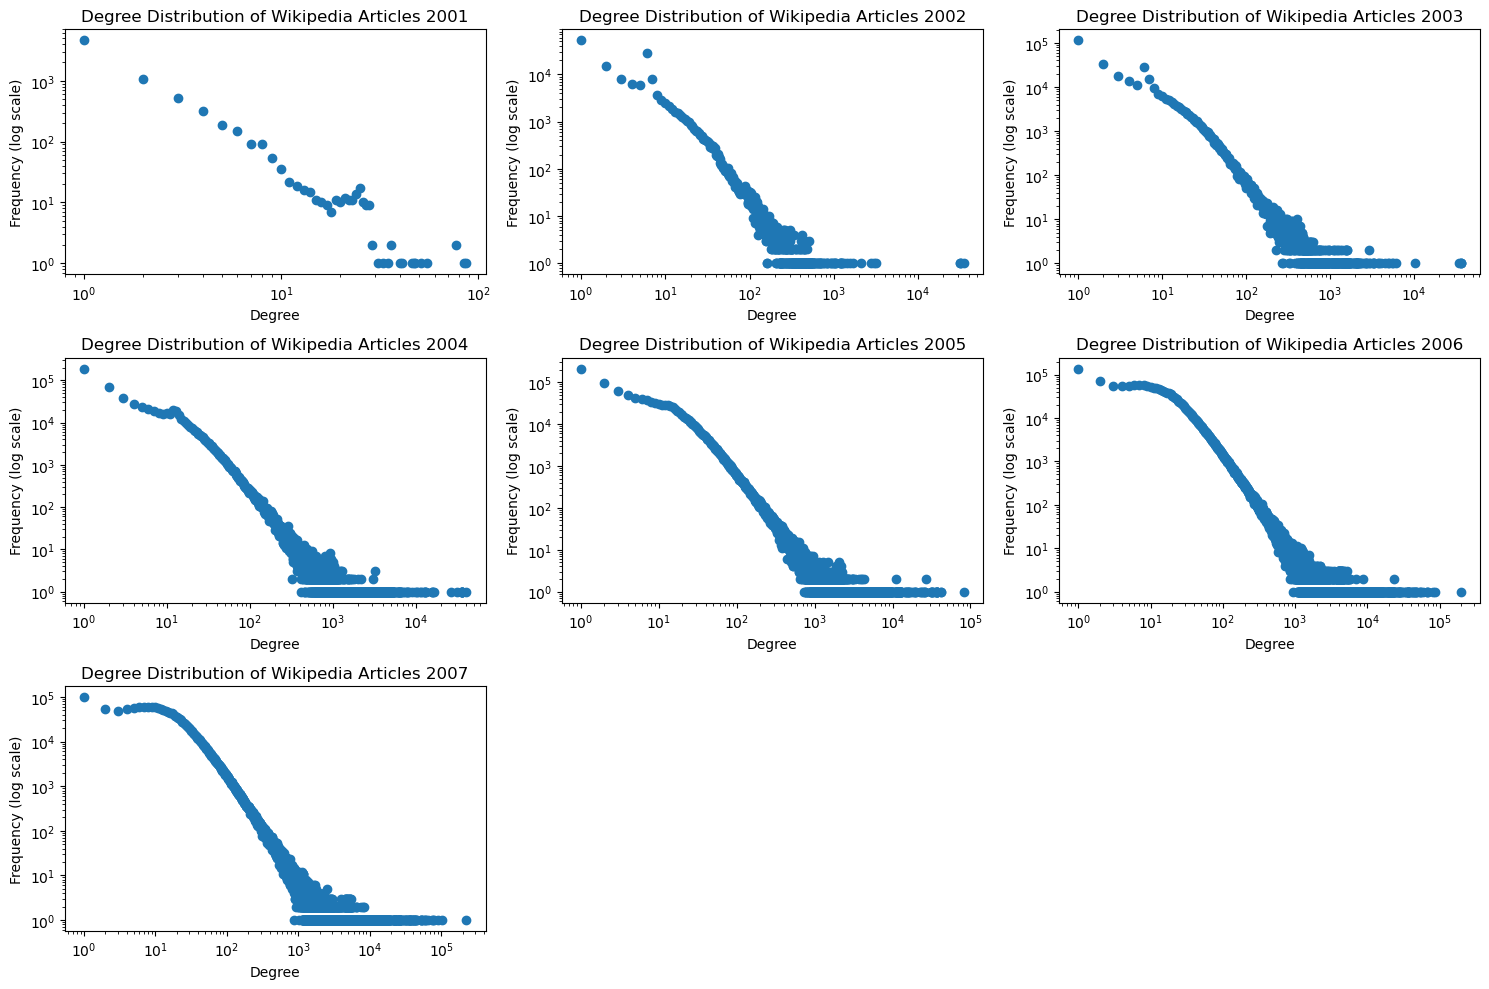

In [5]:
num_subplots = len(subgraphs)
num_cols = 3  
num_rows = (num_subplots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

for i, (subgraph_name, subgraph) in enumerate(subgraphs.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    # Calculate the degree of each vertex in the subgraph
    degrees = subgraph.get_total_degrees(subgraph.get_vertices())

    # Create a histogram of the degree distribution
    hist = gt.vertex_hist(subgraph, "total")

    # Plot the degree distribution as a scatter plot with a label
    year = int(subgraph_name[9:])
    ax.scatter(hist[1][:-1], hist[0], label=f"Degree Distribution of Wikipedia Articles {2000 + year}")

    # Set the plot properties for the subgraph
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency (log scale)")
    ax.set_title(f"Degree Distribution of Wikipedia Articles {2000 + year}")
    ax.grid(False)

# Hide any empty subplots
for i in range(num_subplots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout()
plt.show()

We can also evaluate how both the average degree and the average degree of the network develop over time

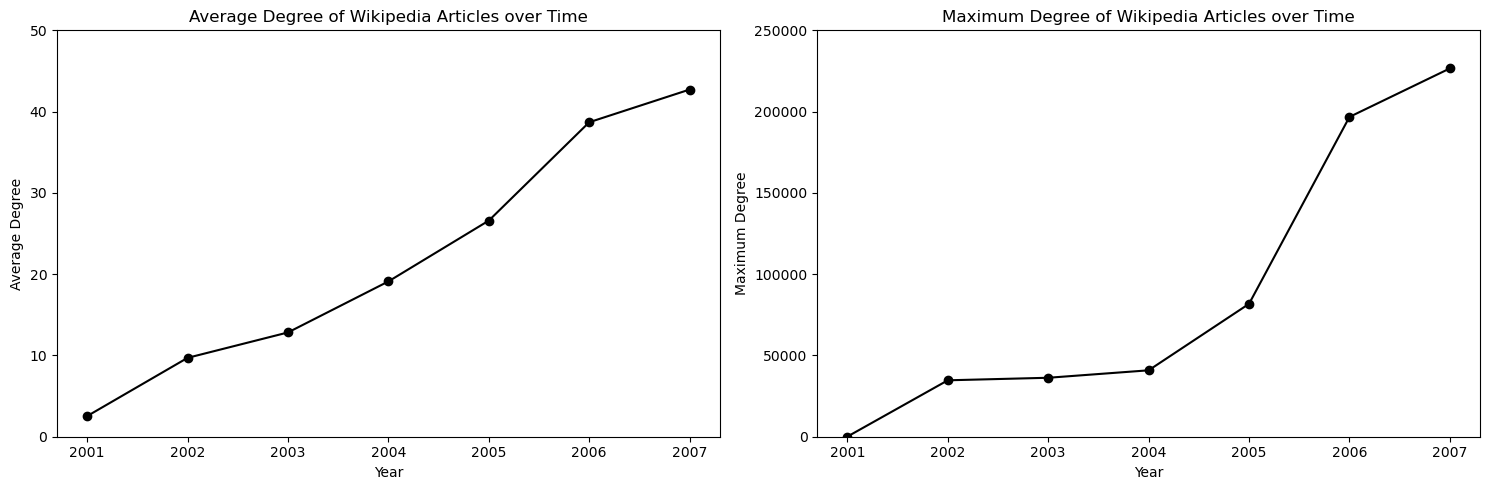

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot: Average Degree
years = []
avg_degrees = []

# Iterate through the years from 2001 to 2007 for average degree
for year in range(2001, 2008):
    # Get the subgraph for the current year from the dictionary
    subgraph_name = f"subgraph{str(year)[2:]}".zfill(2)
    subgraph = subgraphs.get(subgraph_name, None)

    if subgraph is not None:
        # Calculate the average degree of the subgraph
        avg_degree = subgraph.get_total_degrees(subgraph.get_vertices()).mean()

        # Append the year and average degree to the respective lists
        years.append(year)
        avg_degrees.append(avg_degree)

# Plot the average degree on the left subplot
axes[0].plot(years, avg_degrees, marker='o', linestyle='-', color = "black")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Average Degree")
axes[0].set_ylim(0, 50)
axes[0].set_title("Average Degree of Wikipedia Articles over Time")

# Right subplot: Maximum Degree
years = []
max_degrees = []

# Iterate through the years from 2001 to 2007 for maximum degree
for year in range(2001, 2008):
    # Get the subgraph for the current year from the dictionary
    subgraph_name = f"subgraph{str(year)[2:]}".zfill(2)
    subgraph = subgraphs.get(subgraph_name, None)

    if subgraph is not None:
        # Calculate the maximum degree of the subgraph
        max_degree = subgraph.get_total_degrees(subgraph.get_vertices()).max()

        # Append the year and maximum degree to the respective lists
        years.append(year)
        max_degrees.append(max_degree)


axes[1].plot(years, max_degrees, marker='o', linestyle='-', color = "black")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Maximum Degree")
axes[1].set_ylim(0, 250000)
axes[1].set_title("Maximum Degree of Wikipedia Articles over Time")

plt.tight_layout()
plt.show()


In [49]:
# Create a figure with a grid layout for multiple subplots
num_subplots = len(subgraphs)
num_columns = 3  # Adjust the number of columns as needed
num_rows = (num_subplots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

# Iterate through the subgraphs and plot degree correlation for each
for i, (subgraph_name, subgraph) in enumerate(subgraphs.items()):
    row = i // num_columns
    col = i % num_columns

    # Calculate the degree correlation of the subgraph
    degree_corr = gt.local_clustering(subgraph)

    # Plot the degree correlation on the current subplot
    axes[row, col].plot(degree_corr.a, marker='o', linestyle='-')
    axes[row, col].set_xlabel("Vertex")
    axes[row, col].set_ylabel("Degree Correlation")
    axes[row, col].set_title(f"Degree Correlation for {subgraph_name}")

# Remove any empty subplots
for i in range(num_subplots, num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    fig.delaxes(axes[row, col])

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

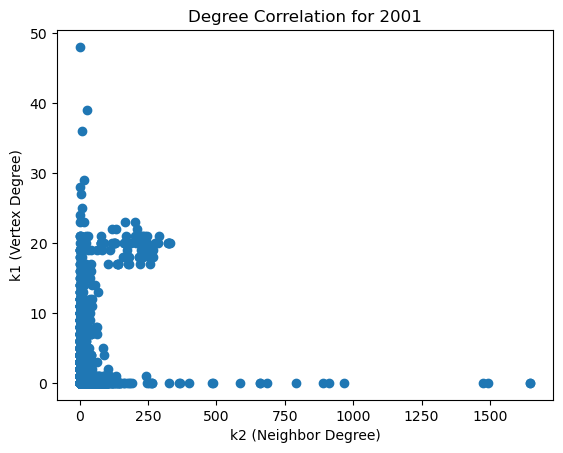

In [22]:
first_subgraph = subgraphs.get("subgraph01")

if first_subgraph is not None:
    # Create arrays to store k1 (vertex degrees) and k2 (neighbor degrees)
    k1 = [v.out_degree() for v in first_subgraph.vertices()]
    k2 = [sum(n.out_degree() for n in v.all_neighbors()) for v in first_subgraph.vertices()]

    # Create a plot for the degree correlation of the first subgraph
    plt.scatter(k2, k1, marker='o')
    plt.xlabel("k2 (Neighbor Degree)")
    plt.ylabel("k1 (Vertex Degree)")
    plt.title(f"Degree Correlation for 2001")

    # Show the plot
    plt.show()

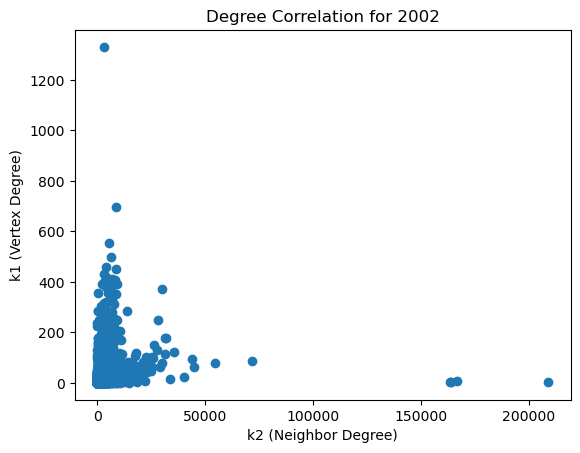

In [17]:
subgraph_02 = subgraphs.get("subgraph02")

if subgraph_02 is not None:
    # Create arrays to store k1 (vertex degrees) and k2 (neighbor degrees)
    k1 = [v.out_degree() for v in subgraph_02.vertices()]
    k2 = [sum(n.out_degree() for n in v.all_neighbors()) for v in subgraph_02.vertices()]

    # Create a plot for the degree correlation of the first subgraph
    plt.scatter(k2, k1, marker='o')
    plt.xlabel("k2 (Neighbor Degree)")
    plt.ylabel("k1 (Vertex Degree)")
    plt.title(f"Degree Correlation for 2002")

    # Show the plot
    plt.show()

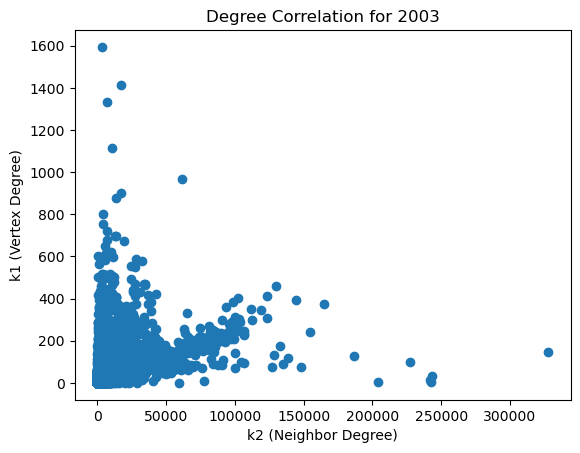

In [6]:
subgraph_03 = subgraphs.get("subgraph03")

if subgraph_03 is not None:
    # Create arrays to store k1 (vertex degrees) and k2 (neighbor degrees)
    k1 = [v.out_degree() for v in subgraph_03.vertices()]
    k2 = [sum(n.out_degree() for n in v.all_neighbors()) for v in subgraph_03.vertices()]

    # Create a plot for the degree correlation of the first subgraph
    plt.scatter(k2, k1, marker='o')
    plt.xlabel("k2 (Neighbor Degree)")
    plt.ylabel("k1 (Vertex Degree)")
    plt.title(f"Degree Correlation for 2003")

    # Show the plot
    plt.show()

In [7]:


# Calculate betweenness centrality
betweenness_centrality = gt.betweenness(g)

# Create a list of vertex indices
vertices = list(g.get_vertices())

# Sort vertices based on degree or betweenness centrality

sorted_vertices_betweenness = sorted(vertices, key=lambda v: betweenness_centrality[v], reverse=True)


# Plot betweenness centrality
plt.subplot(122)
plt.plot(betweenness_centrality.get_array(), 'bo', markersize=3)
plt.title("Betweenness Centrality")
plt.xlabel("Vertex Index")
plt.ylabel("Centrality")

plt.tight_layout()
plt.show()


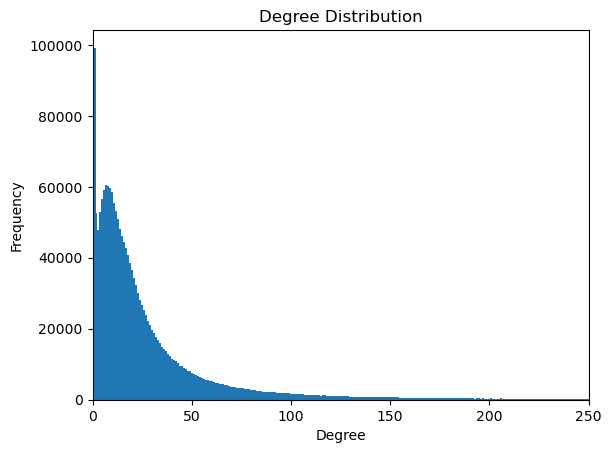

In [ ]:
degrees = g.get_total_degrees(g.get_vertices())

# Create a histogram of degree distribution
hist = gt.vertex_hist(g, "total")

# Plot the degree distribution as a histogram
plt.bar(hist[1][:-1], hist[0], width=1.0, align='center')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.xlim(0, 250)
plt.show()

In [ ]:
import time 

# Convert the UNIX timestamp for the year 2001 to seconds since the epoch
start_time = int(time.mktime(time.strptime("2001-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")))

# Convert the UNIX timestamp for the year 2002 to seconds since the epoch
end_time = int(time.mktime(time.strptime("2002-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")))

# Create an edge filter to select edges within the specified time range
edge_filter = g.new_edge_property("bool")
edge_filter.a = (g.ep.time.a >= start_time) & (g.ep.time.a < end_time)

# Create a subgraph containing only the edges within the time range
subgraph = gt.GraphView(g, efilt=edge_filter)

# Define a layout for the subgraph (you can choose a suitable layout)
subgraph_pos = gt.sfdp_layout(subgraph)

# Plot the subgraph
gt.graph_draw(subgraph, pos=subgraph_pos, output="subgraph_plot.png")

# Show the plot
plt.show()

In [29]:
subgraph = subgraphs.get("subgraph01")

if subgraph is not None:
    # Get the community information stored as a vertex property
    communities = subgraph.vp.communities

    # Create a layout for visualization
    pos = gt.sfdp_layout(subgraph)

    # Create a list of colors for each community
    num_communities = int(communities.a.max()) + 1
    colors = plt.get_cmap('tab20', num_communities)

    # Plot the subgraph with community colors
    gt.graph_draw(
        subgraph,
        pos,
        vertex_fill_color=colors[communities.a.astype(int)],
        vertex_size=20,
        output_size=(800, 800),
        output="community_detection_subgraph01.png",
        output_format="png",
    )

    # Show the plot
    plt.show()

AttributeError: 'super' object has no attribute 'communities'

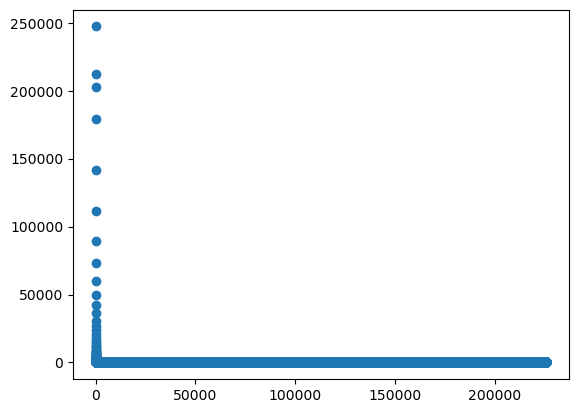

In [ ]:
hist = gt.vertex_hist(g, "in")

plt.scatter(hist[1][:-1], hist[0])

plt.show()

In [14]:
subgraph_01 = subgraphs.get("subgraph01")

if subgraph_01 is not None:
    # Plot the subgraph with edges
    gt.graph_draw(subgraph_01, output_size=(800, 800), output="subgraph_01.png", output_format="png")

/Users/carlogress/anaconda3/envs/gt/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:668: UserWarning: Unknown parameter: output_format
  warnings.warn("Unknown parameter: " + k, UserWarning)


In [ ]:
pos = gt.sfdp_layout(filtered_subgraph)
gt.graph_draw(filtered_subgraph, pos, output=None)
plt.title(f'Wikipedia Growth Network for Year {start_year}')
plt.show()

In [ ]:
in_hist = gt.vertex_hist(g, "in")

out_hist = gt.vertex_hist(g, "out")

In [11]:
y = in_hist[0]
err = np.sqrt(in_hist[0])
plt.errorbar(in_hist[1][:-1], in_hist[0], fmt="o", yerr=err,
        label="in")

y = out_hist[0]
err = np.sqrt(out_hist[0])
plt.errorbar(out_hist[1][:-1], out_hist[0], fmt="o", yerr=err,
        label="out")

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$k$")
plt.ylabel("$NP(k_{in})$")

plt.tight_layout()
plt.legend()

NameError: name 'in_hist' is not defined

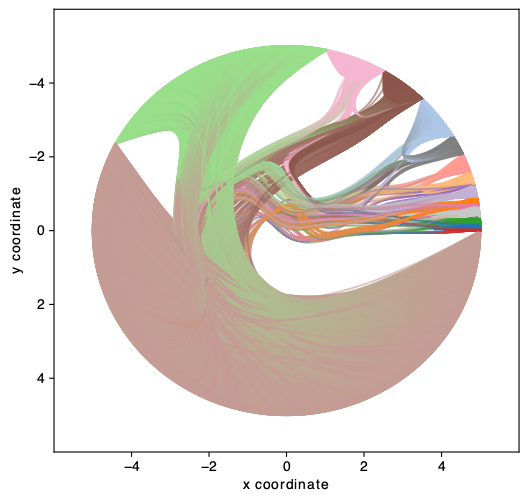

In [36]:
from IPython.display import display

# Assuming "subgraph_01" is stored in the "subgraphs" dictionary
subgraph_01 = subgraphs.get("subgraph01")

plt.switch_backend("cairo")

fig, ax = plt.subplots(1, 1, figsize=(6, 5.75))  # Create a single subplot

# Perform community detection for subgraph_01
state = gt.minimize_nested_blockmodel_dl(subgraph_01)

state.draw(mplfig=ax)  # Use the single subplot

# Display the plot in the notebook
display(fig)

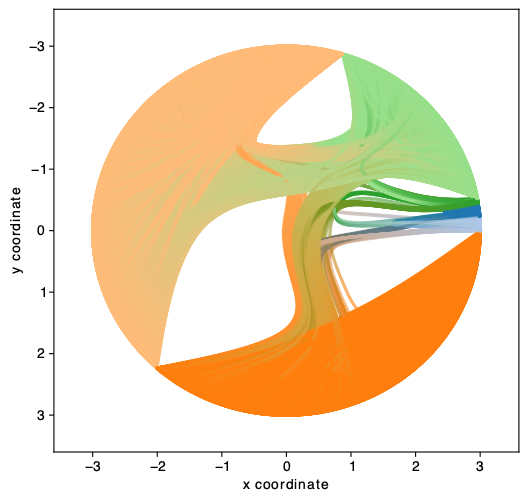

In [37]:
for year in range(1, 8):
    subgraph_name = f"subgraph{str(year).zfill(2)}"
    subgraph = subgraphs.get(subgraph_name)

    plt.switch_backend("cairo")

    fig, ax = plt.subplots(1, 1, figsize=(6, 5.75))

    state = gt.minimize_nested_blockmodel_dl(subgraph)

    state.draw(mplfig=ax)

    ax.set_xlabel("$x$ coordinate")
    ax.set_ylabel("$y$ coordinate")

    # Display the plot in the notebook
    display(fig)

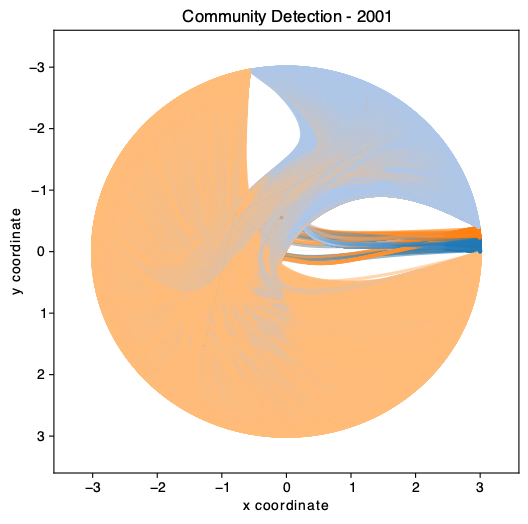

In [6]:
from IPython.display import display

# Assuming "subgraphs" is a dictionary containing subgraphs subgraph01, subgraph02, ..., subgraph07
num_rows = 3
num_cols = 3

# Create a list of years from 2001 to 2007
years = list(range(2001, 2008))

# Iterate through the subgraphs and years
for i, (subgraph_name, year) in enumerate(zip(subgraphs.keys(), years)):
    subgraph = subgraphs.get(subgraph_name)

    plt.switch_backend("cairo")

    fig, ax = plt.subplots(1, 1, figsize=(6, 5.75))

    state = gt.minimize_nested_blockmodel_dl(subgraph)

    state.draw(mplfig=ax)

    ax.set_xlabel("$x$ coordinate")
    ax.set_ylabel("$y$ coordinate")

    # Add a label to the subplot
    ax.set_title(f"Community Detection - {year}")

    # Calculate the row and column index for the subplot
    row = i // num_cols
    col = i % num_cols

    # Display the plot in the specified row and column
    display(fig, display_id=f"plot_{year}", metadata={"mount_id": "image_display", "colab_type": "image"})


In [13]:
subgraph_01 = subgraphs.get("subgraph01")

betweenness, _ = gt.betweenness(subgraph_01)

# Store the betweenness values as a vertex property
subgraph_01.vp.betweenness = betweenness

# Access the betweenness values for vertices
betweenness_values = subgraph_01.vp.betweenness.a

# Calculate the average betweenness
average_betweenness = betweenness_values.mean()

# Print the average betweenness
print(f"Average Betweenness Centrality in subgraph_01: {average_betweenness}")

ValueError: value must be of type PropertyMap, not <class 'tuple'>

In [14]:
years = []
average_betweenness_values = []

# Iterate through the years from 2001 to 2007
for year in range(2001, 2008):
    subgraph_name = f"subgraph{str(year)[2:]}".zfill(2)
    subgraph = subgraphs.get(subgraph_name)
    
    if subgraph is not None:
        betweenness, _ = gt.betweenness(subgraph)
        subgraph.vp.betweenness = betweenness
        betweenness_values = subgraph.vp.betweenness.a
        average_betweenness = betweenness_values.mean()
        years.append(year)
        average_betweenness_values.append(average_betweenness)

# Create a plot to show the development of average betweenness over the years
plt.plot(years, average_betweenness_values, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Betweenness Centrality")
plt.title("Development of Average Betweenness Centrality Over Time")
plt.grid(True)
plt.show()

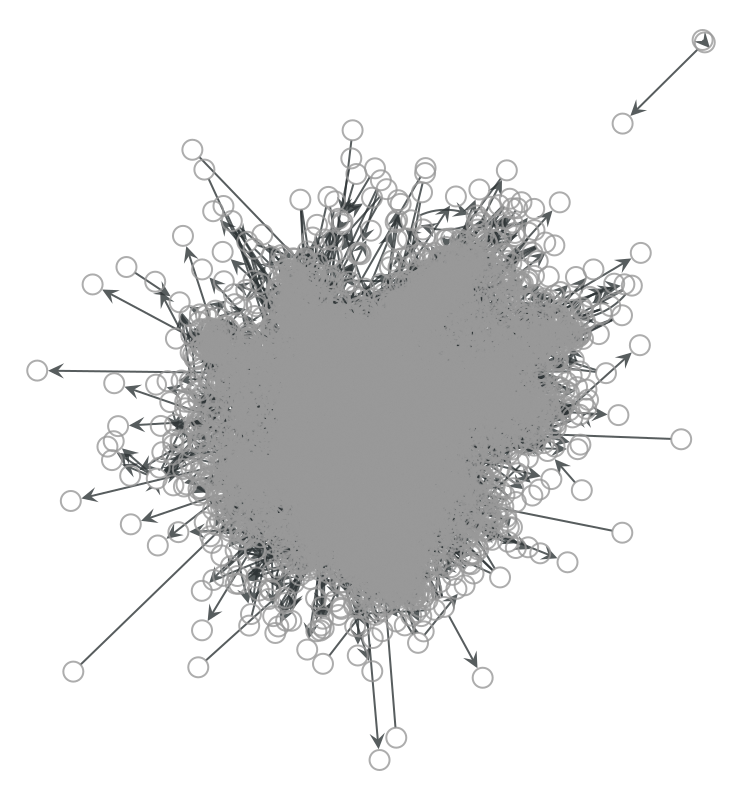

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [12]:
subgraph_01 = subgraphs.get("subgraph01")

closeness = gt.closeness(subgraph_01)

# Create a colormap for vertex colors based on closeness centrality
closeness_colors = gt.graph_draw(
    subgraph_01,
    pos=subgraph_01.vp._pos,
    vertex_fill_color=closeness,
    vertex_size=10,
    output_size=(400, 400)  # Set the output size for the graph visualization
)

# Create a colorbar to represent closeness values
cb = plt.colorbar(orientation="vertical")
cb.set_label("Closeness Centrality")

# Set the plot properties
plt.xlabel("$x$ coordinate")
plt.ylabel("$y$ coordinate")
plt.title("Closeness Centrality Visualization for 2001")

# Show the plot
plt.show()






